# Leveraging PyPowSyBl for Flow‑Based Capacity Calculation

A progressive, hands‑on tutorial to **compute** and **visualize** Flow‑Based domains using **PyPowSyBl**.

## Introduction

Flow‑Based (FB) capacity calculation is the methodology TSOs use in Europe’s Core region to allocate cross‑border transmission capacity while respecting network security. It relies on **linear DC sensitivities**, **critical network elements with contingencies (CNECs)**, **Generation Shift Keys (GSKs)**, and **security margins** to bound the admissible net positions of bidding zones. The key elements listed above are introduced progressively throughout the tutorial.

### Notebook goals
This tutorial is a practical workspace to compute and visualize Flow‑Based domains with PyPowSyBl. We will:
1. Introduce PyPowSyBl’s core features (network model, visualization, and load‑flow).
2. Build a **toy multi‑zone network** and run a **zonal DC sensitivity analysis** (a prerequisite for FB).
3. Construct and visualize the **FB domain** for selected zones.
4. Study how FB **parameters** (CNEs, FRM, contingencies) impact the domain’s shape.


---

## Getting Started

To run the notebook on your machine:
- you should have ```python``` installed on your laptop (**tested with python 3.13**)
- you can install all the required python packages with following command:
  
```bash
pip install -r requirements.txt
```

To start jupyter:

```bash
jupyter notebook FlowBased_PyPowSyBl_Tutorial.ipynb
```

In [ ]:
# command to allow interaction with plots later
%matplotlib widget

---

## A quick tour of PyPowSyBl

The [official documentation of PyPowSyBl](https://powsybl.readthedocs.io/projects/pypowsybl/en/stable/#) is a great starting point to explore the network model, data structures, I/O, and plotting utilities. 

Let's start by importing `pypowsybl`.

In [1]:
import pypowsybl as pp

### The network model and its visualization

The [network model](https://powsybl.readthedocs.io/projects/pypowsybl/en/stable/user_guide/network.html) of PyPowSyBl contains all the data of a power network (substations, generators, lines, transformers, ...). It is the main data structure of pypowsybl, which provides methods to create, modify and visualize networks.

Let's start with IEEE9-bus network, which can be created with a factory method in the library. 

In [2]:
network = pp.network.create_ieee9()

In order to diplay the network, we can draw the network area diagram. This type of diagram displays the voltage levels and how they are connected to each other. 

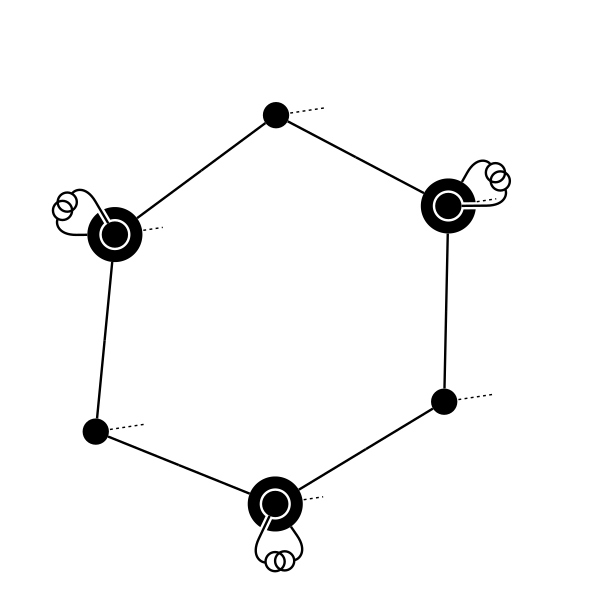

In [3]:
network.get_network_area_diagram()

If you wish to get a more detailed view of the network, featuring each components (busbars, switches, generators, loads, etc.), you can display a single-line diagram. 

Here, we chose to display the single-line diagram of the 'VL1' substation. Observe the busbars 'B1' and 'B4', linked by a transformer, the generator 'B1-G', linked to busbar 'B1', and lines 'L6-4-0' and 'L5-4-0'.

In [4]:
network.get_single_line_diagram('VL1', pp.network.SldParameters(use_name=True))

All the elements of the network can be accessed with the following methods:

| Element | method |
|----|----|
| substations | [``network.get_substations()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_substations.html#pypowsybl.network.Network.get_substations) |
| voltage levels  | [``network.get_voltage_levels()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_voltage_levels.html#pypowsybl.network.Network.get_voltage_levels) |
| buses | [``network.get_buses()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_buses.html#pypowsybl.network.Network.get_buses) |
| loads | [``network.get_loads()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_loads.html#pypowsybl.network.Network.get_loads) |
| generators | [``network.get_generators()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_generators.html#pypowsybl.network.Network.get_generators) |
| lines | [``network.get_lines()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_lines.html#pypowsybl.network.Network.get_lines) |
| 2 windings transformers | [``network.get_2_windings_transformers()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_2_windings_transformers.html#pypowsybl.network.Network.get_2_windings_transformers) |
| dangling lines | [``network.get_dangling_lines()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_dangling_lines.html#pypowsybl.network.Network.get_dangling_lines) |
| tie lines | [``network.get_tie_lines()``](https://powsybl.readthedocs.io/projects/pypowsybl/en/latest/reference/api/pypowsybl.network.Network.get_tie_lines.html#pypowsybl.network.Network.get_tie_lines) |

For a complete description of all the elements of the network and how to interact with them, you can refer to the [corresponding documentation](https://powsybl.readthedocs.io/projects/pypowsybl/en/stable/user_guide/network.html#reading-network-elements-data). 

Let’s take the example of the network’s generators and branches.

In [5]:
generators = network.get_generators()
generators

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
B1-G,,OTHER,71.64102,-9999.0,9999.0,-99990.0,999900.0,NaN,MIN_MAX,104.0,27.04592,True,B1-G,NaN,NaN,NaN,VL1,VL1_0,True
B2-G,,OTHER,163.00000,-9999.0,9999.0,-99990.0,999900.0,NaN,MIN_MAX,102.5,6.65366,True,B2-G,NaN,NaN,NaN,VL2,VL2_0,True
B3-G,,OTHER,85.00000,-9999.0,9999.0,-99990.0,999900.0,NaN,MIN_MAX,102.5,-10.85970,True,B3-G,NaN,NaN,NaN,VL3,VL3_0,True


In [6]:
branches = network.get_branches()
branches

,type,voltage_level1_id,bus1_id,connected1,voltage_level2_id,bus2_id,connected2,p1,q1,i1,p2,q2,i2
id,,,,,,,,,,,,,
L7-8-0,LINE,VL2,VL2_1,True,VL8,VL8_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L9-8-0,LINE,VL3,VL3_1,True,VL8,VL8_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L7-5-0,LINE,VL2,VL2_1,True,VL5,VL5_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L9-6-0,LINE,VL3,VL3_1,True,VL6,VL6_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L5-4-0,LINE,VL5,VL5_0,True,VL1,VL1_1,True,NaN,NaN,NaN,NaN,NaN,NaN
L6-4-0,LINE,VL6,VL6_0,True,VL1,VL1_1,True,NaN,NaN,NaN,NaN,NaN,NaN
T4-1-0,TWO_WINDINGS_TRANSFORMER,VL1,VL1_1,True,VL1,VL1_0,True,NaN,NaN,NaN,NaN,NaN,NaN
T7-2-0,TWO_WINDINGS_TRANSFORMER,VL2,VL2_1,True,VL2,VL2_0,True,NaN,NaN,NaN,NaN,NaN,NaN
T9-3-0,TWO_WINDINGS_TRANSFORMER,VL3,VL3_1,True,VL3,VL3_0,True,NaN,NaN,NaN,NaN,NaN,NaN


Note that no values are provided for the power or current flowing through the branches, since no simulation has yet been run on the network. The next section focuses on performing a load flow simulation on it.

### Load flow simulations

PyPowSyBl provides an interface to PowSyBl’s load flow simulations, which include both DC and AC analyses. The latter solves a system of non-linear equations, known as the load flow equations, which establish the fundamental relationship between bus voltages and active/reactive power injections at each bus under Kirchhoff’s laws.

This analysis computes the voltage magnitude and angle, as well as the power flows on each bus of the network. Let’s run an AC load flow to analyze the base case (i.e., without contingencies, also called the *N case*).

In [7]:
pp.loadflow.run_ac(network)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=Converged, iteration_count=3, reference_bus_id='VL1_0', slack_bus_results=[SlackBusResult(id='VL1_0', active_power_mismatch=-4.324395319610375e-06)], distributed_active_power=0.0)]

The results include all the main information from the simulation (convergence status, number of iterations, slack bus used, unserved active power, etc.). 

To visualize the flows computed by the simulation, you can either inspect the branches directly or display the network area diagram (see [previous section](#the-network-model-and-its-visualization)).

In [8]:
branches

,type,voltage_level1_id,bus1_id,connected1,voltage_level2_id,bus2_id,connected2,p1,q1,i1,p2,q2,i2
id,,,,,,,,,,,,,
L7-8-0,LINE,VL2,VL2_1,True,VL8,VL8_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L9-8-0,LINE,VL3,VL3_1,True,VL8,VL8_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L7-5-0,LINE,VL2,VL2_1,True,VL5,VL5_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L9-6-0,LINE,VL3,VL3_1,True,VL6,VL6_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L5-4-0,LINE,VL5,VL5_0,True,VL1,VL1_1,True,NaN,NaN,NaN,NaN,NaN,NaN
L6-4-0,LINE,VL6,VL6_0,True,VL1,VL1_1,True,NaN,NaN,NaN,NaN,NaN,NaN
T4-1-0,TWO_WINDINGS_TRANSFORMER,VL1,VL1_1,True,VL1,VL1_0,True,NaN,NaN,NaN,NaN,NaN,NaN
T7-2-0,TWO_WINDINGS_TRANSFORMER,VL2,VL2_1,True,VL2,VL2_0,True,NaN,NaN,NaN,NaN,NaN,NaN
T9-3-0,TWO_WINDINGS_TRANSFORMER,VL3,VL3_1,True,VL3,VL3_0,True,NaN,NaN,NaN,NaN,NaN,NaN


It is also possible to run a load flow simulation using a DC approximation of power flows. This can be done easily with the following code.

In [9]:
pp.loadflow.run_dc(network)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=Converged, iteration_count=0, reference_bus_id='VL1_0', slack_bus_results=[SlackBusResult(id='VL1_0', active_power_mismatch=-4.641019999999996)], distributed_active_power=0.0)]

Let’s check the results on the branches. What do you observe ?

In [10]:
branches

,type,voltage_level1_id,bus1_id,connected1,voltage_level2_id,bus2_id,connected2,p1,q1,i1,p2,q2,i2
id,,,,,,,,,,,,,
L7-8-0,LINE,VL2,VL2_1,True,VL8,VL8_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L9-8-0,LINE,VL3,VL3_1,True,VL8,VL8_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L7-5-0,LINE,VL2,VL2_1,True,VL5,VL5_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L9-6-0,LINE,VL3,VL3_1,True,VL6,VL6_0,True,NaN,NaN,NaN,NaN,NaN,NaN
L5-4-0,LINE,VL5,VL5_0,True,VL1,VL1_1,True,NaN,NaN,NaN,NaN,NaN,NaN
L6-4-0,LINE,VL6,VL6_0,True,VL1,VL1_1,True,NaN,NaN,NaN,NaN,NaN,NaN
T4-1-0,TWO_WINDINGS_TRANSFORMER,VL1,VL1_1,True,VL1,VL1_0,True,NaN,NaN,NaN,NaN,NaN,NaN
T7-2-0,TWO_WINDINGS_TRANSFORMER,VL2,VL2_1,True,VL2,VL2_0,True,NaN,NaN,NaN,NaN,NaN,NaN
T9-3-0,TWO_WINDINGS_TRANSFORMER,VL3,VL3_1,True,VL3,VL3_0,True,NaN,NaN,NaN,NaN,NaN,NaN


The DC load flow simulation is partly used by PyPowSyBl’s DC sensitivity analysis. The following section shows how to perform such an analysis.

### DC sensitivity analysis

A nodal DC sensitivity analysis evaluates, within the DC approximation of the power system, the marginal impact of an injection change (generation or load) at a given node on power flows. We are talking about Power Transfer Distribution Factors (PTDFs), in this case nodal PTDFs, since the variation is evaluated at the node level.

Let’s create the runner that will launch such analysis.

In [11]:
dc_sa = pp.sensitivity.create_dc_analysis()

In order to perform a sensitivity analysis with pypowsybl, you must first define the “factors” you want to compute. What we call a factor is the impact of a small variation of a variable (e.g., the active power injection of a generator), on a function (e.g., the active power flow on a branch).

In the following example, we are going to assess the effect of increasing the production of generator 'B2-G' on the lines of our network. 

Pypowsybl provides a method to define the variables and functions through their ids.

In [12]:
dc_sa.add_branch_flow_factor_matrix(
    branches_ids=branches.index, 
    variables_ids=['B2-G']
)

Let's run the sensitivity analysis.

In [13]:
result = dc_sa.run(network)

We obtain a matrix of sensitivities as a result.

In [14]:
result.get_sensitivity_matrix()

id,L7-8-0,L9-8-0,L7-5-0,L9-6-0,L5-4-0,L6-4-0,T4-1-0,T7-2-0,T9-3-0
B2-G,0.36134,-0.36134,0.63866,0.36134,0.63866,0.36134,1.0,-1.0,4.736446e-16


Thus, a 1-MW increase at generator 'B2-G' results in a 0.36-MW increase in active power flow on line 'L7-8-0', from side 1 to side 2.

For more information on PyPowSyBl’s sensitivity calculations, the reader can refer to a dedicated PowSyBl notebook, freely available [here](https://github.com/powsybl/pypowsybl-notebooks/blob/main/sensitivity_analysis.ipynb).

---

## Modeling and Visualizing a Flow‑Based Domain with PyPowSyBl

### Flow‑Based Capacity Calculation

#### Context

Flow-based capacity calculation is the method used for computation of cross-borders capacities in the Core region. This method determines, for each market zone, the maximum possible cross-border exchange capacities while simultaneously accounting for the physical constraints of the power grid (power flows and security margins) to ensure safe and efficient trading. 

These maximum exchange capacities are represented by a secure domain in the space of net positions $np_z$, each corresponding to the difference between the power exported and imported by zone $z$. The following figure illustrates an example of a commercial exchange space in a toy network that will be detailed later in the tutorial.

<img src="../images/3D_fb_domain.png" alt="title" width="50%">

Each dimension corresponds to the range of possible commercial exchanges for a specific hub (i.e., a bidding zone or a virtual hub created for modelling purposes). In the following, we will only refer to bidding zones, or zones, denoted by the set $ZONES$. It is within the boundaries of this domain that EUPHEMIA (the Pan-European Hybrid Electricity Market Integration Algorithm) seeks the optimum of European social welfare. The steps to compute this domain, called the Flow-Based domain, within the Core region are documented [here](https://www.entsoe.eu/bites/ccr-core/day-ahead/). 

In the remainder of this tutorial, we focus exclusively on constructing a Flow-Based domain with PyPowSyBl and on its visualization.

#### Flow-Based domain

Let $CNECs$ denote the set of critical network elements for a contingency, defining the Flow-Based domain. With $PTDF_{z,c}$ denoting the impact in terms of flow of zone $z$ on CNEC $c$, and $RAM_c$ the remaining available margin of CNEC $c$, the equations defining the domain are:

$$\sum_{z\in ZONES} PTDF_{z,c} np_z \leq RAM_c \qquad \forall c \in CNECs \qquad (1)$$

$$\sum_{z\in ZONES} np_z = 0 \qquad (2)$$

Equation $(1)$ ensures that each CNEC of the network is not congested for any possible commercial exchange. Equation $(2)$ ensures that the Flow-Based domain describes sets of net positions that make sense from a modelling perspective: the sum of the net positions of all zones must be zero (what is exported must be imported somewhere else within the Flow-Based area). 

The Flow-Based domain is therefore the intersection of a polyhedron (or polytope), arising from constraints $(1)$, and a hyperplane (equation $(2)$).

The previous domain comes from a toy network studied in [(Felten et al., 2016)](https://www.sciencedirect.com/science/article/pii/S0957178720301302). To visualize its Flow-Based domain, we must first build this network with PyPowSyBl. The next section is dedicated to this.


### Building a toy network

We set up a small **multi‑zone** system (e.g., FR, DE, BE) to make the algebra transparent. This network is only for illustration but captures the essential features needed to compute PTDFs and a Flow‑Based domain. It is taken from the study conducted in [(Felten et al., 2016)](https://www.sciencedirect.com/science/article/pii/S0957178720301302), and resembles the network illustrated below.

Building such a network can be done easily with PyPowSyBl’s functions.

In [15]:
import pandas as pd

# Initialize an empty network
network: pp.network.Network = pp.network.create_empty()

# Create bidding zones as substations (using PyPowSyBl substations)
network.create_substations(id=["FR", "DE", "BE"])
network.update_substations(id=["FR"], TSO=["RTE"], country=["FR"])
network.update_substations(id=["DE"], TSO=["Tennet"], country=["DE"])
network.update_substations(id=["BE"], TSO=["Elia"], country=["BE"])

# Create one voltage level per zone
voltage_levels = pd.DataFrame.from_records(
    index="id",
    data=[
        {"substation_id": "FR", "id": "Z_FR", "topology_kind": "BUS_BREAKER", "nominal_v": 1},
        {"substation_id": "DE", "id": "Z_DE", "topology_kind": "BUS_BREAKER", "nominal_v": 1},
        {"substation_id": "BE", "id": "Z_BE", "topology_kind": "BUS_BREAKER", "nominal_v": 1},
    ],
)
network.create_voltage_levels(voltage_levels)

# Add buses in the different zones
network.create_buses(
    id=["B1", "B2", "B3", "B4"],
    voltage_level_id=["Z_FR", "Z_DE", "Z_DE", "Z_BE"],
)

# Create lines (assume identical impedances to simplify calculations)
network.create_lines(
    id="alpha", name="alpha",
    voltage_level1_id="Z_FR",  bus1_id="B1",
    voltage_level2_id="Z_DE", bus2_id="B2",
    b1=0, b2=0, g1=0, g2=0, r=0, x=1,
)
network.create_lines(
    id="beta", name="beta",
    voltage_level1_id="Z_FR",  bus1_id="B1",
    voltage_level2_id="Z_BE",  bus2_id="B4",
    b1=0, b2=0, g1=0, g2=0, r=0, x=1,
)
network.create_lines(
    id="gamma", name="gamma",
    voltage_level1_id="Z_DE", bus1_id="B2",
    voltage_level2_id="Z_DE", bus2_id="B3",
    b1=0, b2=0, g1=0, g2=0, r=0, x=1,
)
network.create_lines(
    id="delta", name="delta",
    voltage_level1_id="Z_DE", bus1_id="B2",
    voltage_level2_id="Z_BE", bus2_id="B4",
    b1=0, b2=0, g1=0, g2=0, r=0, x=1,
)
network.create_lines(
    id="epsilon", name="epsilon",
    voltage_level1_id="Z_DE", bus1_id="B3",
    voltage_level2_id="Z_BE", bus2_id="B4",
    b1=0, b2=0, g1=0, g2=0, r=0, x=1,
)

Now, let’s visualize the network we just built. We use the same function as in section [Network model and its visualization](#the-network-model-and-its-visualization), where the display is configured for improved rendering.

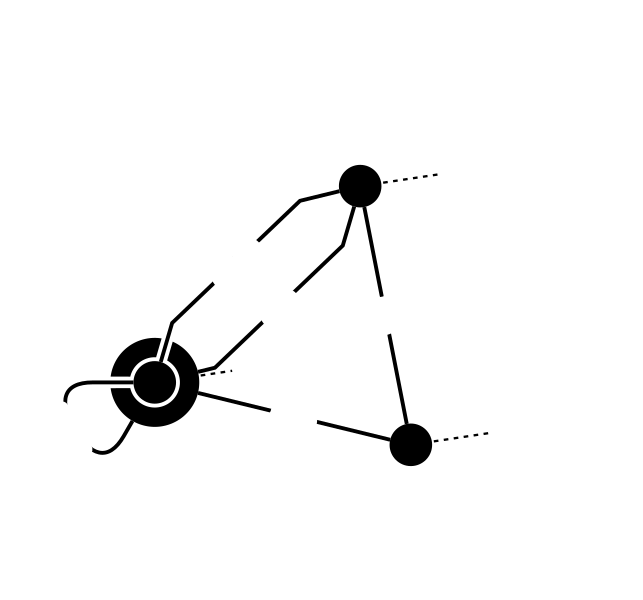

In [16]:
network.get_network_area_diagram(
    nad_parameters=pp.network.NadParameters(
        edge_name_displayed=True, 
        id_displayed=True, 
        edge_info_along_edge=False, 
        bus_legend=False, 
        substation_description_displayed=False, 
    )
)

### Zone‑to‑zone sensitivity: PTDF computation

Section [DC sensitivity analysis](#dc-sensitivity-analysis) showed how to compute nodal PTDFs with PyPowSyBl. The PTDFs used in the Flow-Based domain equations (see [Flow-Based domain](#flow-based-domain)) are zonal PTDFs, i.e., mapping the variation of injection in zone $z$ to the flows on the different CNECs.

The two categories of PTDFs are related. Indeed, from the nodal DC sensitivity matrix, we aggregate to zones using **Generation Shift Keys** (GSKs) to obtain zonal PTDFs. The GSKs indicate how the total net position of a zone is distributed among its generators (or nodes), thus defining how a zonal injection change is translated into nodal injections and corresponding line flows.

Let’s start by adding loads and generators to enable the computation of nodal PTDFs.

In [17]:
# loads in the grid
network.create_loads(
    id="LOAD_FR", voltage_level_id="Z_FR", bus_id="B1", p0=150, q0=0
)
network.create_loads(
    id="LOAD_BE", voltage_level_id="Z_BE", bus_id="B4", p0=150, q0=0
)

# production capacities in the grid
network.create_generators(
    id="G1", voltage_level_id="Z_FR", bus_id="B1",
    min_p=0, max_p=150, target_p=75,
    voltage_regulator_on=True, target_v=1,
)
network.create_generators(
    id="G11", voltage_level_id="Z_FR", bus_id="B1",
    min_p=0, max_p=200, target_p=75,
    voltage_regulator_on=True, target_v=1,
)
network.create_generators(
    id="G2", voltage_level_id="Z_DE", bus_id="B2",
    min_p=0, max_p=1200, target_p=50,
    voltage_regulator_on=True, target_v=1,
)
network.create_generators(
    id="G2_wind", voltage_level_id="Z_DE", bus_id="B2",
    min_p=0, max_p=200, target_p=25,
    voltage_regulator_on=True, target_v=1,
)
network.create_generators(
    id="G3", voltage_level_id="Z_DE", bus_id="B3",
    min_p=0, max_p=300, target_p=75,
    voltage_regulator_on=True, target_v=1,
)
network.create_generators(
    id="G4", voltage_level_id="Z_BE", bus_id="B4",
    min_p=0, max_p=150, target_p=75,
    voltage_regulator_on=True, target_v=1,
)

Then, in order to compute zonal PTDFs with PyPowSyBl, we must define zones, with associated GSKs.

In [18]:
# here we use GSK proportional to generators targets for each zone
zone_fr = pp.sensitivity.create_country_zone(network, "FR", key_type=pp.sensitivity.ZoneKeyType.GENERATOR_TARGET_P)
zone_de = pp.sensitivity.create_country_zone(network, "DE", key_type=pp.sensitivity.ZoneKeyType.GENERATOR_TARGET_P)
zone_be = pp.sensitivity.create_country_zone(network, "BE", key_type=pp.sensitivity.ZoneKeyType.GENERATOR_TARGET_P)

Now let’s add these zones to a DC sensitivity simulator in order to perform a zonal DC sensitivity analysis.

In [19]:
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones(zones=[zone_fr, zone_de, zone_be])

Let’s start with the case where the critical elements are only the network lines (base case, no contingencies) — i.e., the **CNEs**. We want to assess how each zone’s net position affects these branches. This can be added easily with the following code.

In [20]:
cne = network.get_branches().index
sa.add_branch_flow_factor_matrix(cne, variables_ids=["FR", "DE", "BE"])

Let’s run the sensitivity analysis we just set up.

In [21]:
parameters_lf = pp.loadflow.Parameters(
    distributed_slack=True,
    connected_component_mode=pp.loadflow.ConnectedComponentMode.MAIN,
)
sa_result = sa.run(network, parameters_lf)

Now let's visualize the results.

In [22]:
base_case_zone_ptdf = sa_result.get_sensitivity_matrix().T
print(base_case_zone_ptdf)

               FR        DE        BE
id                                   
alpha    0.491477 -0.071023  0.116477
beta     0.349432 -0.088068 -0.275568
gamma   -0.002841 -0.190341 -0.127841
delta   -0.142045 -0.017045 -0.392045
epsilon -0.139205  0.173295 -0.264205


To make it easier to work with the resulting dataframe, we update its indexing.

In [23]:
LABEL_CNE_ID = "CNE_id"
base_case_zone_ptdf[LABEL_CNE_ID] = base_case_zone_ptdf.index
base_case_zone_ptdf = base_case_zone_ptdf.reset_index(drop=True)
base_case_zone_ptdf = base_case_zone_ptdf.set_index([LABEL_CNE_ID])
print(base_case_zone_ptdf)

               FR        DE        BE
CNE_id                               
alpha    0.491477 -0.071023  0.116477
beta     0.349432 -0.088068 -0.275568
gamma   -0.002841 -0.190341 -0.127841
delta   -0.142045 -0.017045 -0.392045
epsilon -0.139205  0.173295 -0.264205


Each value of this matrix indicates how the flow is distributed on a given CNE (rows), for a variation in a given zone (columns).

### Remaining Available Margins

**Remaining Available Margins** (RAM) is the right-hand side of the Flow-Based equations introduced in Section [Flow-Based domain](#flow-based-domain). It corresponds to the margin left on a CNEC for market exchanges after accounting for base case flows and security margins. A common formulation is $RAM = F_{max} - F_0 - FRM$, possibly adjusted by other security parameters, with:
- $F_{max}$: the maximum thermal capacity of the line (or CNEC), i.e., the physical operational limit.
- $F_0$: the reference/base case flow on the line before considering additional commercial exchanges.
- $FRM$: the Flow Reliability Margin, a security margin accounting for uncertainties in flows (e.g., forecast errors, model approximations).

In the following, to simplify our calculations, we assume (unless stated otherwise) that $RAM = F_{max}$.

Let’s add *operational limits* $F_{max}$ to our CNEs.

In [24]:
# These limits represent the maximum admissible active power (MW) flow
# on the line before it is considered overloaded.
network.create_operational_limits(
    element_id="alpha", side="ONE",
    name="MW", type="ACTIVE_POWER",
    value=75, acceptable_duration=-1,
)
network.create_operational_limits(
    element_id="beta", side="ONE",
    name="MW", type="ACTIVE_POWER",
    value=75, acceptable_duration=-1,
)
network.create_operational_limits(
    element_id="gamma", side="ONE",
    name="MW", type="ACTIVE_POWER",
    value=130, acceptable_duration=-1,
)
network.create_operational_limits(
    element_id="delta", side="ONE",
    name="MW", type="ACTIVE_POWER",
    value=50, acceptable_duration=-1,
)
network.create_operational_limits(
    element_id="epsilon", side="ONE",
    name="MW", type="ACTIVE_POWER",
    value=130, acceptable_duration=-1,
)

We retrieve the operational limits of the lines.

In [25]:
limits = network.get_operational_limits()
print(limits)

           element_type side             name          type  value  \
element_id                                                           
alpha              LINE  ONE  permanent_limit  ACTIVE_POWER   75.0   
beta               LINE  ONE  permanent_limit  ACTIVE_POWER   75.0   
gamma              LINE  ONE  permanent_limit  ACTIVE_POWER  130.0   
delta              LINE  ONE  permanent_limit  ACTIVE_POWER   50.0   
epsilon            LINE  ONE  permanent_limit  ACTIVE_POWER  130.0   

            acceptable_duration  
element_id                       
alpha                        -1  
beta                         -1  
gamma                        -1  
delta                        -1  
epsilon                      -1  


We remove unnecessary columns and reindex the dataframe to simplify handling.

In [26]:
# remove useless columns for FB calculation
ratings_power = limits[["value", "side"]]

# reindex the dataframe
ratings_power.index.name = LABEL_CNE_ID
ratings_power = ratings_power.rename(columns={"value": "ram", "side": "direction"})
print(ratings_power)

           ram direction
CNE_id                  
alpha     75.0       ONE
beta      75.0       ONE
gamma    130.0       ONE
delta     50.0       ONE
epsilon  130.0       ONE


Each RAM value is interpreted as the maximum flow that can circulate on a CNE.

### Flow‑Based domain dataframe

We assemble all pieces (**zonal PTDFs**, **RAM**, and **CNE metadata**) into a single dataframe. This table is the canonical input to building linear inequalities of the FB domain.

In [27]:
flow_based_domain = base_case_zone_ptdf.merge(ratings_power, left_index=True, right_index=True)
print(flow_based_domain)

               FR        DE        BE    ram direction
CNE_id                                                
alpha    0.491477 -0.071023  0.116477   75.0       ONE
beta     0.349432 -0.088068 -0.275568   75.0       ONE
gamma   -0.002841 -0.190341 -0.127841  130.0       ONE
delta   -0.142045 -0.017045 -0.392045   50.0       ONE
epsilon -0.139205  0.173295 -0.264205  130.0       ONE


In order to obtain a convex space, the constraints for each CNE must be defined in both possible directions of power flow. For simplicity, we assume that the limits are also valid in the opposite direction. Let’s add these constraints to the dataframe corresponding to our Flow-Based domain.

In [28]:
df_direction_two = flow_based_domain.assign(direction='TWO', **{c:-flow_based_domain[c] for c in ['FR','DE','BE']}).set_axis(flow_based_domain.index.map(str)+'_2')
flow_based_domain = pd.concat([flow_based_domain, df_direction_two]).sort_index() # sort to improve readiness
print(flow_based_domain)

                 FR        DE        BE    ram direction
CNE_id                                                  
alpha      0.491477 -0.071023  0.116477   75.0       ONE
alpha_2   -0.491477  0.071023 -0.116477   75.0       TWO
beta       0.349432 -0.088068 -0.275568   75.0       ONE
beta_2    -0.349432  0.088068  0.275568   75.0       TWO
delta     -0.142045 -0.017045 -0.392045   50.0       ONE
delta_2    0.142045  0.017045  0.392045   50.0       TWO
epsilon   -0.139205  0.173295 -0.264205  130.0       ONE
epsilon_2  0.139205 -0.173295  0.264205  130.0       TWO
gamma     -0.002841 -0.190341 -0.127841  130.0       ONE
gamma_2    0.002841  0.190341  0.127841  130.0       TWO


Each row defines one of the inequalities $(1)$, called PTDF constraints, introduced in Section [Flow-Based domain](#flow-based-domain).

### Visualization

Let’s add the functions to visualize the Flow-Based domain built in the previous section in 3D. They allow us to display the polytope corresponding to the intersection of the PTDF constraints, as well as the hyperplane corresponding to the balance of net positions (see [Introduction to Flow-Based Capacity Calculation](#introduction-to-flow-based-capacity-calculation)).

In [29]:
import numpy as np
from scipy.spatial import ConvexHull, HalfspaceIntersection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def get_3D_domain_convex_hull(flow_based_domain, zones: list[str]):
    """
    Compute the convex hull of the Flow-Based domain in 3D.

    Parameters
    ----------
    flow_based_domain : DataFrame
        Contains the PTDF values per zone and the RAM for each CNEC.
    zones : list of str
        The three bidding zones we want to project the domain onto.

    Returns
    -------
    vertices : ndarray
        Coordinates of the intersection points of all half-spaces.
    hull : ConvexHull
        The convex hull object built from the vertices.
    """
    # Build half-space constraints from PTDFs and RAM values
    halfspaces = []
    for cnec in flow_based_domain.index:
        ram = flow_based_domain.loc[cnec, "ram"]
        ptdfs = [flow_based_domain.loc[cnec, zone] for zone in zones]
        # Each constraint has the form: sum_z PTDF_z * np_z <= RAM
        halfspaces.append(ptdfs + [-ram])
    halfspaces = np.array(halfspaces)

    # Choose an interior point guaranteed to be in the domain (origin works)
    interior_point = np.array([0, 0, 0])

    # Compute half-space intersection and extract vertices
    hs = HalfspaceIntersection(halfspaces, interior_point)
    vertices = hs.intersections

    # Build convex hull from the intersection points
    hull = ConvexHull(vertices)
    return vertices, hull


def plot_3d_domain(flow_based_domain, zones, axis_eps: float = 2e-1):
    """
    Plot the Flow-Based domain in 3D.

    Parameters
    ----------
    flow_based_domain : DataFrame
        Contains PTDFs and RAMs for each CNEC.
    zones : list of str
        Names of the three bidding zones to be used as axes.
    axis_eps : float
        Small margin to enlarge axis limits (for visualization clarity).
    """

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # --- Compute convex hull of the FB domain ---
    vertices, hull = get_3D_domain_convex_hull(flow_based_domain, zones)

    # Axis limits with a small expansion factor for readability
    x_min, x_max = vertices[:, 0].min() * (1 + axis_eps), vertices[:, 0].max() * (1 + axis_eps)
    y_min, y_max = vertices[:, 1].min() * (1 + axis_eps), vertices[:, 1].max() * (1 + axis_eps)
    z_min, z_max = vertices[:, 2].min() * (1 + axis_eps), vertices[:, 2].max() * (1 + axis_eps)

    # --- Plot convex hull faces ---
    hull_faces = []
    for simplex in hull.simplices:
        face = vertices[simplex]
        poly = Poly3DCollection([face], alpha=0.5, facecolor="white", edgecolor="k")
        ax.add_collection3d(poly)
        hull_faces.append(poly)

    # --- Plot the balance hyperplane (sum of net positions = 0) ---
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
    zz = -xx - yy  # enforce np1 + np2 + np3 = 0
    plane = ax.plot_surface(xx, yy, zz, alpha=0.3)
    plane.set_visible(True)

    # --- Formatting axes ---
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel(f"Net Position {zones[0]} (MW)")
    ax.set_ylabel(f"Net Position {zones[1]} (MW)")
    ax.set_zlabel(f"Net Position {zones[2]} (MW)")
    ax.set_title("Flow-Based domain", fontsize=10, fontweight="bold")

    plt.show()

Let’s display the Flow-Based domain computed in the [previous section](#flow-based-domain-dataframe).

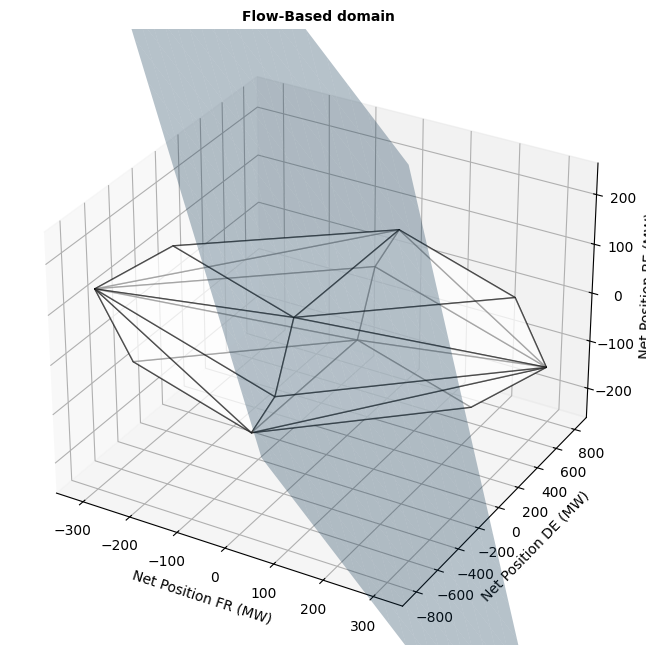

In [31]:
plot_3d_domain(flow_based_domain=flow_based_domain, zones=["FR", "DE", "BE"])

### Domain visualization with contingencies

Up to now, the domain has been displayed for the base case (or CNEs). Now, we include *contingencies* explicitly and compare the domain with and without contingencies to quantify their *tightening effect*.

To do so, we add post-contingency cases to the sensitivity analysis, i.e., for each CNE we add a contingency corresponding to one of the network’s lines.

In [32]:
for contingency in cne:
    sa.add_single_element_contingency(contingency)

We rerun the sensitivity analysis to compute the post-contingency sensitivity factors.

In [33]:
sa_result = sa.run(network, parameters_lf)

As in the previous sections, we build the dataframe for the Flow-Based domain. For easier handling, the indices of the dataframes resulting from the zonal sensitivity analysis are reordered. To do so, we are going to use the following function:

In [34]:
from pandas import DataFrame

LABEL_CONT_ID = "contingency_id"
def format_ptdf_matrix(sensitivity_matrix:DataFrame, contingency_id=None):
    sensitivity_matrix[LABEL_CNE_ID] = sensitivity_matrix.index
    sensitivity_matrix[LABEL_CONT_ID] = "" if contingency_id is None else contingency_id
    sensitivity_matrix = sensitivity_matrix.reset_index(drop=True)
    sensitivity_matrix.set_index([LABEL_CNE_ID, LABEL_CONT_ID])
    return sensitivity_matrix.set_index([LABEL_CNE_ID, LABEL_CONT_ID])

Let’s start with the dataframe corresponding to the base case.

In [35]:
base_case_ptdf = sa_result.get_sensitivity_matrix().T
base_case_ptdf = format_ptdf_matrix(base_case_ptdf)
print(base_case_ptdf)

                              FR        DE        BE
CNE_id  contingency_id                              
alpha                   0.491477 -0.071023  0.116477
beta                    0.349432 -0.088068 -0.275568
gamma                  -0.002841 -0.190341 -0.127841
delta                  -0.142045 -0.017045 -0.392045
epsilon                -0.139205  0.173295 -0.264205


Let’s do the same for the post-contingency sensitivity factors.

In [36]:
ptdf = base_case_ptdf
for contingency in cne:
    post_cont_ptdf = sa_result.get_sensitivity_matrix(contingency_id=contingency).T
    post_cont_ptdf = format_ptdf_matrix(post_cont_ptdf, contingency_id=contingency)
    ptdf = pd.concat([ptdf, post_cont_ptdf])
print(ptdf)

                              FR        DE        BE
CNE_id  contingency_id                              
alpha                   0.491477 -0.071023  0.116477
beta                    0.349432 -0.088068 -0.275568
gamma                  -0.002841 -0.190341 -0.127841
delta                  -0.142045 -0.017045 -0.392045
epsilon                -0.139205  0.173295 -0.264205
alpha   alpha           0.000000  0.000000  0.000000
beta    alpha           0.840909 -0.159091 -0.159091
gamma   alpha          -0.166667 -0.166667 -0.166667
delta   alpha          -0.469697  0.030303 -0.469697
epsilon alpha          -0.303030  0.196970 -0.303030
alpha   beta            0.840909 -0.159091 -0.159091
beta    beta            0.000000  0.000000  0.000000
gamma   beta            0.113636 -0.219697 -0.219697
delta   beta            0.090909 -0.075758 -0.575758
epsilon beta           -0.022727  0.143939 -0.356061
alpha   gamma           0.492424 -0.007576  0.159091
beta    gamma           0.348485 -0.151515 -0.

We can now build our Flow-Based domain.

In [37]:
flow_based_domain = ptdf.merge(ratings_power, left_index=True, right_index=True)
print(flow_based_domain)

                              FR        DE        BE    ram direction
CNE_id  contingency_id                                               
alpha                   0.491477 -0.071023  0.116477   75.0       ONE
beta                    0.349432 -0.088068 -0.275568   75.0       ONE
gamma                  -0.002841 -0.190341 -0.127841  130.0       ONE
delta                  -0.142045 -0.017045 -0.392045   50.0       ONE
epsilon                -0.139205  0.173295 -0.264205  130.0       ONE
alpha   alpha           0.000000  0.000000  0.000000   75.0       ONE
beta    alpha           0.840909 -0.159091 -0.159091   75.0       ONE
gamma   alpha          -0.166667 -0.166667 -0.166667  130.0       ONE
delta   alpha          -0.469697  0.030303 -0.469697   50.0       ONE
epsilon alpha          -0.303030  0.196970 -0.303030  130.0       ONE
alpha   beta            0.840909 -0.159091 -0.159091   75.0       ONE
beta    beta            0.000000  0.000000  0.000000   75.0       ONE
gamma   beta        

Each row defines one of the inequalities $(1)$, called PTDF constraints, introduced in Section [Flow-Based domain](#flow-based-domain). Now, there is one row for each line–contingency combination (a CNEC).

As before, we add the limits in the opposite direction of the power flow.

In [38]:
df_direction_two = flow_based_domain.assign(direction='TWO', **{c:-flow_based_domain[c] for c in ['FR','DE','BE']})
# this time, indices are 2 dimensionnal
index = df_direction_two.index
index_cne = index.get_level_values(0).astype(str) + "2"
df_direction_two.index = pd.MultiIndex.from_arrays([index_cne, index.get_level_values(1)], names=index.names)

flow_based_domain = pd.concat([flow_based_domain, df_direction_two]).sort_index() # sort to improve readiness

We can now visualize the convex domain. What observations can be made?

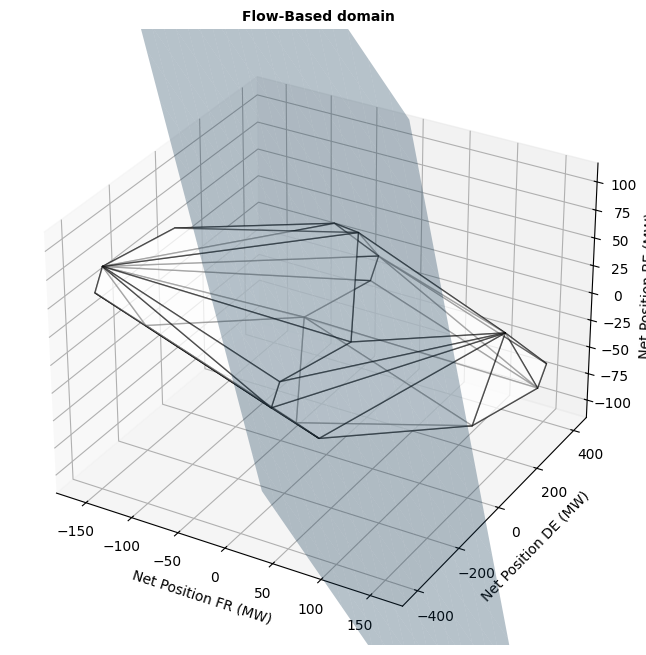

In [39]:
plot_3d_domain(flow_based_domain=flow_based_domain, zones=["FR", "DE", "BE"])

### Domain visualization with FRM

**FRM** has been introduced in Section X. We now add it to RAM calculation to illustrate how security margins and policy choices impact the market domain. Increasing FRM (or raising minRAM binding CNECs) typically **shrinks** the admissible region. 

Let's start with a $FRM$ value proportional to the operational limit $F_{max}$ of the lines.

In [40]:
frm = 0.1

Let us now change the calculation of the $RAM$ of the CNECs in order to observe the impact of the $FRM$. We take the previous Flow-Based domain and add the columns we need.

In [41]:
fb_domain_with_frm = flow_based_domain
fb_domain_with_frm['fmax'] = fb_domain_with_frm['ram']
fb_domain_with_frm['frm'] = frm * fb_domain_with_frm['fmax']

We redefine the $RAM$ of the CNECs as $RAM = F_{max} - FRM$.

In [42]:
fb_domain_with_frm['ram'] = fb_domain_with_frm['fmax'] - fb_domain_with_frm['frm']
print(fb_domain_with_frm)

                               FR        DE        BE    ram direction   fmax  \
CNE_id   contingency_id                                                         
alpha                    0.491477 -0.071023  0.116477   67.5       ONE   75.0   
         alpha           0.000000  0.000000  0.000000   67.5       ONE   75.0   
         beta            0.840909 -0.159091 -0.159091   67.5       ONE   75.0   
         delta           0.562500 -0.062500  0.312500   67.5       ONE   75.0   
         epsilon         0.537879 -0.128788  0.204545   67.5       ONE   75.0   
         gamma           0.492424 -0.007576  0.159091   67.5       ONE   75.0   
alpha2                  -0.491477  0.071023 -0.116477   67.5       TWO   75.0   
         alpha          -0.000000 -0.000000 -0.000000   67.5       TWO   75.0   
         beta           -0.840909  0.159091  0.159091   67.5       TWO   75.0   
         delta          -0.562500  0.062500 -0.312500   67.5       TWO   75.0   
         epsilon        -0.5

We now can visualize the domain taking $FRM$ into account.

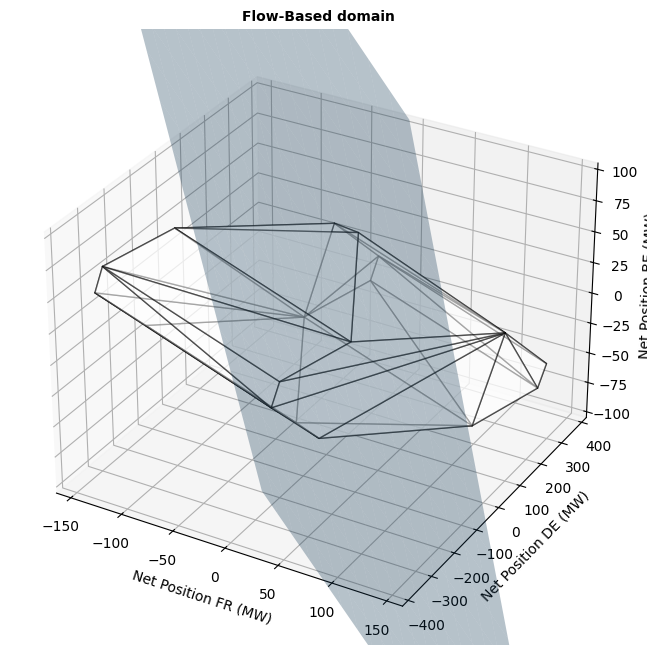

In [43]:
plot_3d_domain(flow_based_domain=fb_domain_with_frm, zones=["FR", "DE", "BE"])

What observations can be made? You can vary the values of $FRM$ and visualize the resulting domains.

---

## Conclusion and next steps

In this notebook, we have:
- Designed a toy multi-zone network in PyPowSyBl,  
- Computed DC sensitivities and derived zonal PTDFs via GSKs,  
- Defined RAMs and assembled the corresponding CNEC constraints,  
- Plotted and analyzed the Flow-Based domain under base case, contingencies, and FRM assumptions.  

Potential next steps:
- Import a realistic network of your choice and construct its Flow-Based domain.  
- Explore alternative **capacity calculation** approaches with PyPowSyBl (e.g., NTC computations as illustrated in this tutorial).  
- Extend the analysis to compare how different assumptions (e.g., FRM sizing, GSK selection, contingency sets) shape the admissible exchange domain.  


---

## References

- *Introduction to PyPowSyBl: Network representation, load‑flow, and plotting* (notebook), Alexandre Marié, Coline Piloquet, and Sophie Frasnedo.
- *Using PyPowSyBl to assess transfer capacity of new electrical interconnections* (notebook), Fabrice Guy, 2024.
- *The flow-based market coupling domain - Why we can't get it right*, Felten et al, 2016.
- *Core Flow‑Based Market Coupling*, by ENTSO-E.